In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

In [195]:
#Construct an ImageDataGenerator object:
DIRECTORY = "Covid19-dataset/train"
CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)
BATCH_SIZE = 16

training_data_generator = ImageDataGenerator(rescale=1.0/255,

#Randomly increase or decrease the size of the image by up to 10%
#previously 0.1
zoom_range=0.2, 

#Randomly rotate the image between -25,25 degrees
rotation_range=25, 

#Shift the image along its width by up to +/- 5%
width_shift_range=0.2, 

#Shift the image along its height by up to +/- 5%
height_shift_range=0.2,

horizontal_flip = True

)

validation_data_generator = ImageDataGenerator()

In [478]:
training_iterator = training_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical',color_mode='grayscale',batch_size=BATCH_SIZE,shuffle=True)#, subset='training')

next(training_iterator)

print("\nLoading validation data...")


validation_iterator = validation_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical', color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='validation')

Found 251 images belonging to 3 classes.

Loading validation data...
Found 251 images belonging to 3 classes.


In [480]:
#Print its attributes:
# print(training_data_generator.__dict__)


print("\nBuilding model...")

def design_model(training_data):
    # sequential model
    model = Sequential()
    # add input layer with grayscale image shape
    model.add(tf.keras.Input(shape=(256, 256, 1)))
    # convolutional hidden layers with relu functions
    # maxpooling layers and dropout layers as well
    model.add(layers.Conv2D(5, 5, strides=3, activation="relu")) 
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(3, 3, strides=1, activation="relu")) 
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.2))

    # experimenting with extra layesr
    # model.add(tf.keras.layers.Conv2D(3, 3, strides=1, activation="relu"))
    # model.add(layers.MaxPooling2D(
    #     pool_size=(2, 2), strides=(2,2)))
    # model.add(layers.Dropout(0.2))
    # model.add(tf.keras.layers.Conv2D(1, 1, strides=1, activation="relu"))
    # model.add(tf.keras.layers.Dropout(0.1))

    model.add(layers.Flatten())
    # output layer with softmax activation function
    model.add(layers.Dense(3,activation="softmax"))
    
    # compile model with Adam optimizer
    # loss function is categorical crossentropy
    # metrics are categorical accuracy and AUC
    print("\nCompiling model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()],)
    # summarize model    
    model.summary()
    return model


Building model...


In [482]:
# use model function
model = design_model(training_iterator)


Compiling model...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 84, 84, 5)      │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 42, 42, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 42, 42, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 40, 40, 3)      │           138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         3,603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,871 (15.12 KB)

 Trainable params: 3,871 (15.12 KB)

 Non-trainable params: 0 (0.00 B)

In [484]:
# early stopping implementation
es = EarlyStopping(monitor='val_auc_5', mode='min', verbose=1, patience=15)

In [486]:
print("\nTraining model...")
# fit the model with 10 ephochs and early stopping
history =model.fit(
        training_iterator,
        steps_per_epoch=int(training_iterator.samples/BATCH_SIZE), epochs=25,
        validation_data=validation_iterator,
        validation_steps=int(validation_iterator.samples/BATCH_SIZE),
        callbacks=[es])


Training model...
Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - auc_5: 0.5660 - categorical_accuracy: 0.5041 - loss: 1.0972 - val_auc_5: 0.5812 - val_categorical_accuracy: 0.4417 - val_loss: 46.9279
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc_5: 0.3838 - categorical_accuracy: 0.2500 - loss: 1.1588 - val_auc_5: 0.5909 - val_categorical_accuracy: 0.4545 - val_loss: 39.1634
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - auc_5: 0.5698 - categorical_accuracy: 0.4370 - loss: 1.0882 - val_auc_5: 0.5820 - val_categorical_accuracy: 0.4417 - val_loss: 23.7555
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc_5: 0.5762 - categorical_accuracy: 0.3750 - loss: 1.0886 - val_auc_5: 0.6591 - val_categorical_accuracy: 0.5455 - val_loss: 23.7438
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - auc_5: 0.6193 - categorical_accuracy: 0.4335 - loss: 1.0615 - val_auc_5: 0.6433 - val_categorical_accuracy: 0.5167 - val_loss: 40.4579
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s

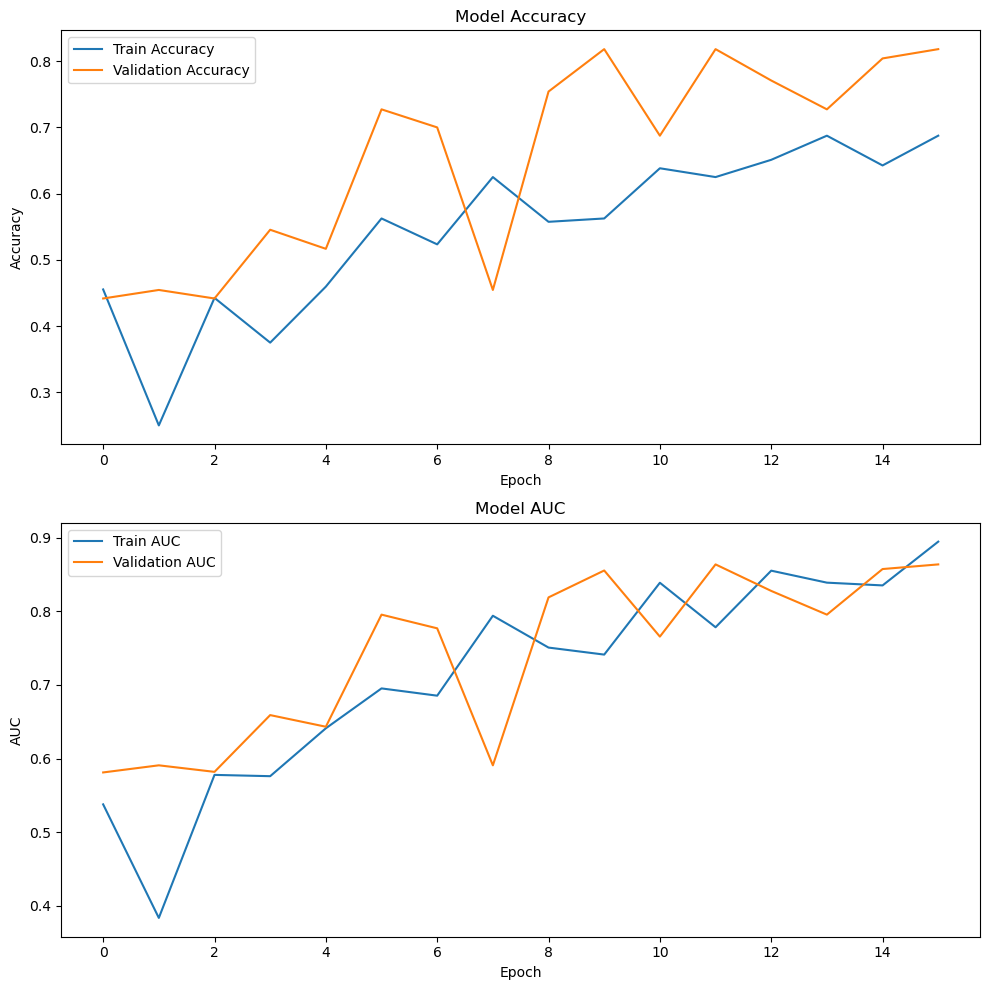

In [490]:

# Plotting categorical and validation accuracy over epochs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(history.history['categorical_accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plotting auc and validation auc over epochs
ax2.plot(history.history['auc_5'], label='Train AUC')
ax2.plot(history.history['val_auc_5'], label='Validation AUC')
ax2.set_title('Model AUC')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC')
ax2.legend()

# Adjusting space between subplots
plt.subplots_adjust(hspace=0.4)

plt.tight_layout()
plt.show()


In [508]:
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
              precision    recall  f1-score   support

       Covid       0.50      0.51      0.51       111
      Normal       0.30      0.46      0.36        70
   Pneumonia       0.38      0.17      0.24        70

    accuracy                           0.40       251
   macro avg       0.39      0.38      0.37       251
weighted avg       0.41      0.40      0.39       251



In [510]:
cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

[[57 44 10]
 [28 32 10]
 [28 30 12]]
